In [311]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

## 1. SHAP PLOT With Data Preprocessing

In [312]:
folder_path = 'neutra_000905.XSHG'  # With Data Preprocessing
# folder_path = '000905.XSHG' # Without Data Preprocessing
csv_files = glob.glob(f"{folder_path}/*.csv")
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    filename_without_extension = os.path.splitext(filename)[0]
    df['time'] = filename_without_extension
    merged_df = pd.concat([merged_df, df], ignore_index=True)

merged_df.rename(columns={merged_df.columns[0]: 'code'}, inplace=True)

merged_df.head()

,code,pe_ratio,pb_ratio,ps_ratio,pcf_ratio,financial_leverage_ratio,debte_to_quity_ratio,cash_ratio,current_ratio,gross_profit_margin,...,BIAS,PSY,DIF,DEA,MACD,ATR14,HSL,circulating_market_cap,market_cap,time
0,000006.XSHE,-0.097099,0.105552,-0.152594,-0.006966,-1.030405,-0.335289,0.881787,-0.411092,1.282566,...,-0.389633,-1.435175,-0.264364,-0.200889,-0.295010,0.552528,0.451993,-0.114794,-0.452665,2021-03-31
1,000012.XSHE,0.210642,0.024228,-0.022009,-0.514909,-0.851328,-0.444497,-0.906465,1.982380,-0.579946,...,2.862316,-0.191976,0.539210,0.413101,0.569246,0.491734,1.416164,0.947998,2.449944,2021-03-31
2,000021.XSHE,0.023253,-0.802121,-1.329841,-0.422718,1.192674,-0.343782,-3.176696,0.891663,-1.247778,...,-0.371584,-0.393121,-0.035268,-0.032420,0.047927,-0.955677,-1.227795,1.042273,0.035235,2021-03-31
3,000030.XSHE,-0.245944,-0.309749,0.027665,-0.022643,-0.849078,-0.014844,-0.012362,-0.534532,0.002175,...,0.292325,-0.587747,0.875335,0.880282,0.472146,-0.958395,-0.320008,-1.599106,-0.584886,2021-03-31
4,000031.XSHE,-0.205785,0.140232,-0.583121,0.036823,0.814751,1.166357,0.808327,-0.165323,-0.447723,...,0.158692,0.239195,-0.512533,-0.750154,0.297742,0.168850,-0.266911,1.648049,1.103632,2021-03-31


In [313]:
# folder_path = 'neutra_000905.XSHG'  # With Data Preprocessing
folder_path = '000905.XSHG' # Without Data Preprocessing
csv_files = glob.glob(f"{folder_path}/*.csv")
merged_df_raw = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    filename_without_extension = os.path.splitext(filename)[0]
    df['time'] = filename_without_extension
    merged_df_raw = pd.concat([merged_df_raw, df], ignore_index=True)

merged_df_raw.rename(columns={merged_df_raw.columns[0]: 'code'}, inplace=True)

merged_df_raw.head()

,code,pe_ratio,pb_ratio,ps_ratio,pcf_ratio,financial_leverage_ratio,debte_to_quity_ratio,cash_ratio,current_ratio,gross_profit_margin,...,BIAS,PSY,DIF,DEA,MACD,ATR14,HSL,circulating_market_cap,market_cap,time
0,000008.XSHE,143.9918,0.8860,2.4369,20.5556,1.676328,0.129172,5.428204,0.703209,40.91,...,-3.007200,40.0,-0.034249,-0.028463,-0.011572,0.07,0.430109,61.0327,63.6802,2021-03-31
1,000009.XSHE,33.8303,3.2343,2.0995,19.3731,2.405103,0.532770,1.806480,0.545849,32.80,...,-3.440559,45.0,0.073578,0.220519,-0.293882,0.22,1.049064,221.4642,223.8758,2021-03-31
2,000012.XSHE,26.8655,1.9002,1.8791,256.7667,1.718555,0.329923,2.295198,0.887762,32.91,...,-0.370870,40.0,-0.121508,-0.133696,0.024376,0.18,0.940865,123.0990,193.1465,2021-03-31
3,000021.XSHE,33.4408,3.7181,1.8836,-128.0980,2.943924,0.213205,11.803247,0.873307,11.18,...,-4.179882,45.0,-0.467703,-0.281264,-0.372877,0.40,0.664286,281.0244,281.4519,2021-03-31
4,000027.XSHE,13.7442,1.9532,2.7046,62.0390,2.724646,0.975950,3.156124,1.282508,36.25,...,22.211787,60.0,1.688815,1.164294,1.049042,0.97,6.504324,533.7791,533.7791,2021-03-31


<Axes: xlabel='financial_leverage_ratio', ylabel='Density'>

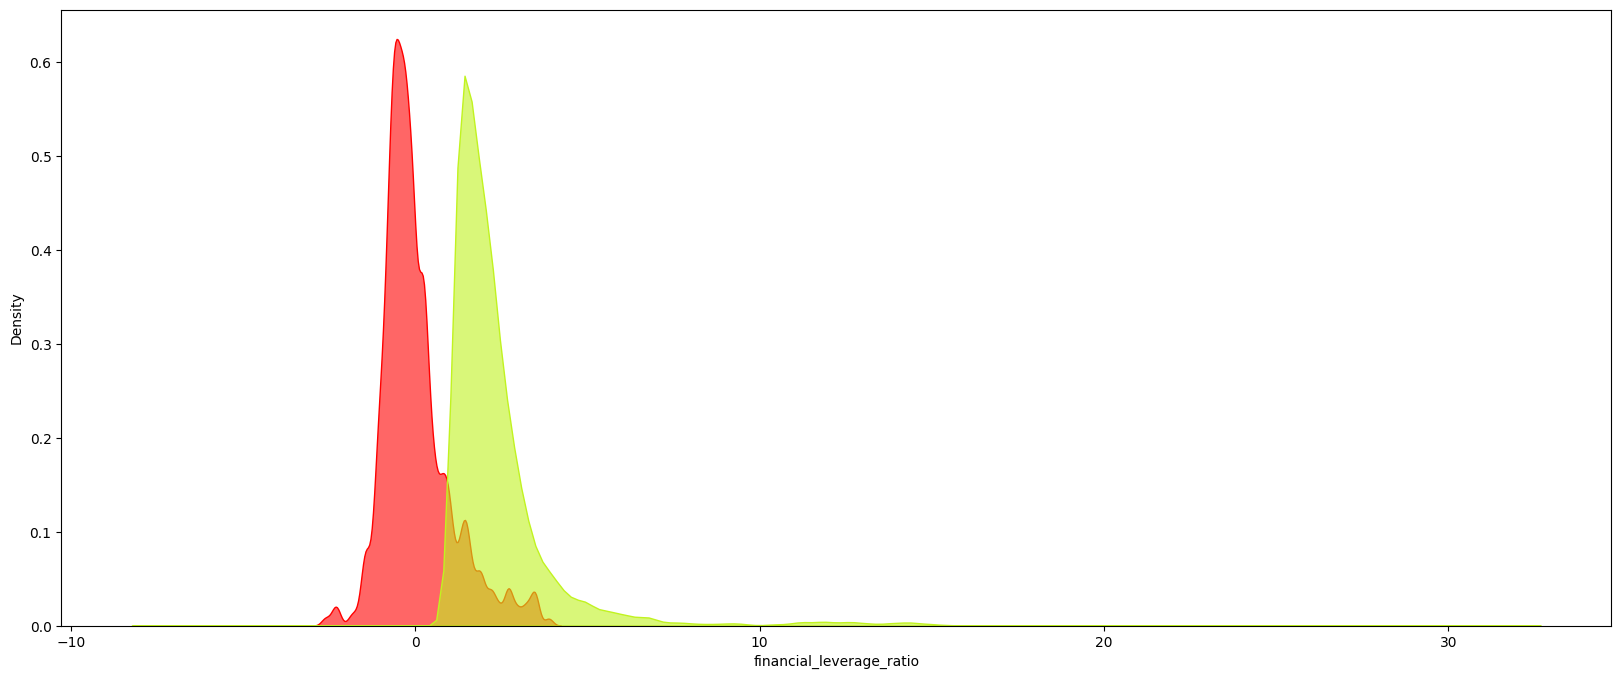

In [314]:
# Inspect the distribution of the financial_leverage_ratio before and after preprocessing

raw_pe_ratio = merged_df_raw['financial_leverage_ratio'] # financial_leverage_ratio
preprocessed_pe_ratio = merged_df['financial_leverage_ratio']

fig = plt.figure(figsize = (20, 8))

sns.kdeplot(preprocessed_pe_ratio, label = 'preprocessed', color="#FF0000", alpha=.6, fill=True)
sns.kdeplot(raw_pe_ratio, label = 'raw', color="#C1F320", alpha=.6, fill=True)

## Combine Price_df and merged_df

In [315]:
price_df = pd.read_csv('stock_prices.csv')
merged_df_with_price = pd.merge(merged_df, price_df, on=['code', 'time'], how='inner') # inner join to remove rows with no price data
merged_df_with_price.shape

(44832, 28)

## Compute Monthly Return

In [316]:
# Create a new DataFrame for calculating monthly returns
df_monthly_returns = merged_df_with_price.copy()

# Convert 'time' to datetime format for easier manipulation
df_monthly_returns['time'] = pd.to_datetime(df_monthly_returns['time'])

# Ensure the DataFrame is sorted by 'code' and 'time' to correctly calculate changes
df_monthly_returns.sort_values(by=['code', 'time'], inplace=True)

# Calculate the monthly return for each stock
df_monthly_returns['return'] = df_monthly_returns.groupby('code')['close'].pct_change()


/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/559623594.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_monthly_returns['return'] = df_monthly_returns.groupby('code')['close'].pct_change()


## Labelling

In [317]:
def label_data(data, drop_columns=['time', 'close', 'return', 'market_cap', 'circulating_market_cap', 'code'], dropna=True):
    data['return_bin'] = np.nan
    data = data.sort_values(by='return', ascending=False)

    # the top 30% of the stocks are labeled as 1, the bottom 30% are labeled as 0
    n_stock_select = np.multiply(0.3, data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)
    data.iloc[:n_stock_select, -1] = 1
    data.iloc[-n_stock_select:, -1] = 0
    
    for column in drop_columns:
        if column in data.columns:
            data.drop(column, axis=1, inplace=True)
    if dropna:
        data = data.dropna()
    return data

In [318]:
# Splitting the dataset into training and testing based on the specified years
train_df = df_monthly_returns[(df_monthly_returns['time'] >= '2016-01-01') & (df_monthly_returns['time'] <= '2019-12-31')]
test_df = df_monthly_returns[(df_monthly_returns['time'] >= '2020-01-01') & (df_monthly_returns['time'] <= '2023-12-31')]

In [319]:
# Apply the labeling function to both training and testing datasets
train_df_labeled = label_data(train_df, dropna=True).reset_index(drop=True)
test_df_labeled = label_data(test_df, dropna=True).reset_index(drop=True)

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/304938115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return_bin'] = np.nan
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/304938115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return_bin'] = np.nan


## Feature Selection 

In [320]:
X = train_df_labeled.iloc[:,:-1]
y = train_df_labeled['return_bin']

In [321]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=10,max_depth=2)

result = xgb.fit(X,y).feature_importances_
result

array([0.05970464, 0.        , 0.08176622, 0.        , 0.        ,
       0.        , 0.04872052, 0.05596597, 0.        , 0.06128248,
       0.05136201, 0.05807824, 0.06874564, 0.04193173, 0.05457681,
       0.        , 0.08447371, 0.06634299, 0.0319562 , 0.13868839,
       0.        , 0.        , 0.09640438], dtype=float32)

## Training, Plotting and evaluation

In [322]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=10,max_depth=2)
xgb.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Plotting SHAP Plot With Data Preprocessing

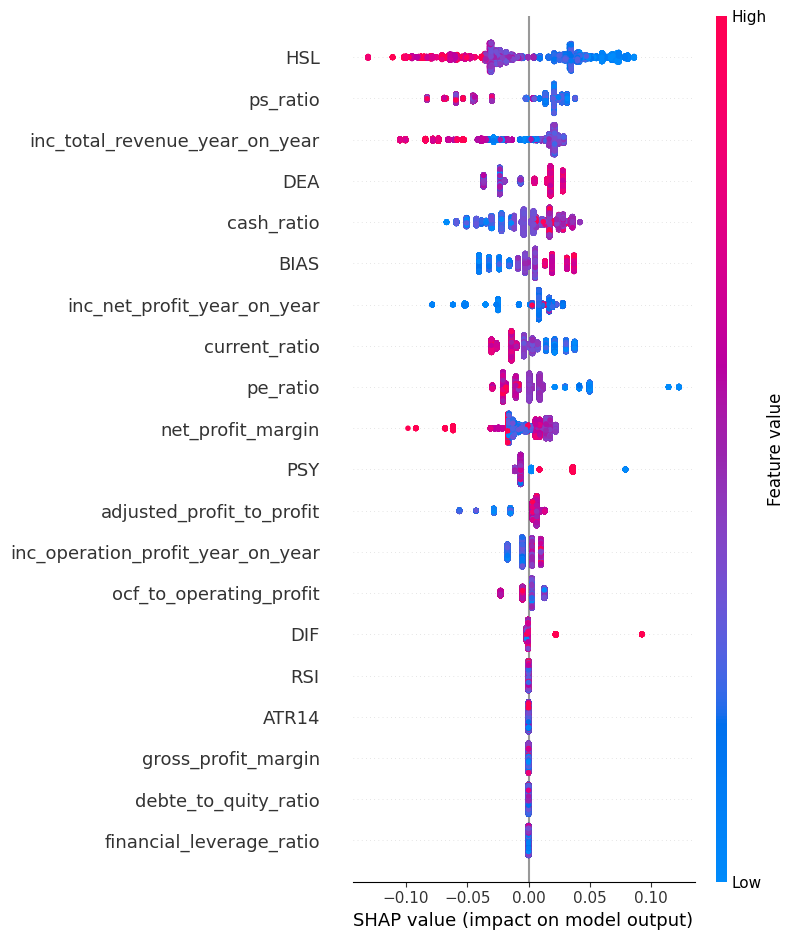

In [323]:
!pip install shap
import shap
X_test = test_df_labeled.iloc[:, :-1]
y_test = test_df_labeled['return_bin']
# X_test_transformed = selector.transform(X_test)  # Transform test data with the same selector used for training

# Initialize the SHAP explainer with the model
explainer = shap.TreeExplainer(xgb.get_booster())

# Calculate SHAP values for the transformed test data
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values - Summary Plot as an example
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())

## 2.0 SHAP Plot Without Data Preprocessing

In [294]:
folder_path = '000905.XSHG' # Without Data Preprocessing
csv_files = glob.glob(f"{folder_path}/*.csv")
merged_df = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.basename(file)
    filename_without_extension = os.path.splitext(filename)[0]
    df['time'] = filename_without_extension
    merged_df = pd.concat([merged_df, df], ignore_index=True)

merged_df.rename(columns={merged_df.columns[0]: 'code'}, inplace=True)

merged_df_with_price = pd.merge(merged_df, price_df, on=['code', 'time'], how='inner') # inner join to remove rows with no price data
merged_df_with_price.shape

# Create a new DataFrame for calculating monthly returns
df_monthly_returns = merged_df_with_price.copy()

# Convert 'time' to datetime format for easier manipulation
df_monthly_returns['time'] = pd.to_datetime(df_monthly_returns['time'])

# Ensure the DataFrame is sorted by 'code' and 'time' to correctly calculate changes
df_monthly_returns.sort_values(by=['code', 'time'], inplace=True)

# Calculate the monthly return for each stock
df_monthly_returns['return'] = df_monthly_returns.groupby('code')['close'].pct_change()

# Splitting the dataset into training and testing based on the specified years
train_df = df_monthly_returns[(df_monthly_returns['time'] >= '2016-01-01') & (df_monthly_returns['time'] <= '2019-12-31')]
test_df = df_monthly_returns[(df_monthly_returns['time'] >= '2020-01-01') & (df_monthly_returns['time'] <= '2023-12-31')]

# Apply the labeling function to both training and testing datasets
train_df_labeled = label_data(train_df, dropna=True).reset_index(drop=True)
test_df_labeled = label_data(test_df, dropna=True).reset_index(drop=True)

# Model Training
X = train_df_labeled.iloc[:,:-1]
y = train_df_labeled['return_bin']

xgb = XGBClassifier(n_estimators=10,max_depth=2)
result = xgb.fit(X,y).feature_importances_
result

/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/3931498815.py:27: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_monthly_returns['return'] = df_monthly_returns.groupby('code')['close'].pct_change()
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/304938115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['return_bin'] = np.nan
/var/folders/q8/7k15ycnj4wv5m475fprntzjh0000gn/T/ipykernel_83482/304938115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32560378, 0.0803531 , 0.02413439, 0.5432372 , 0.        ,
       0.02667147, 0.        , 0.        ], dtype=float32)

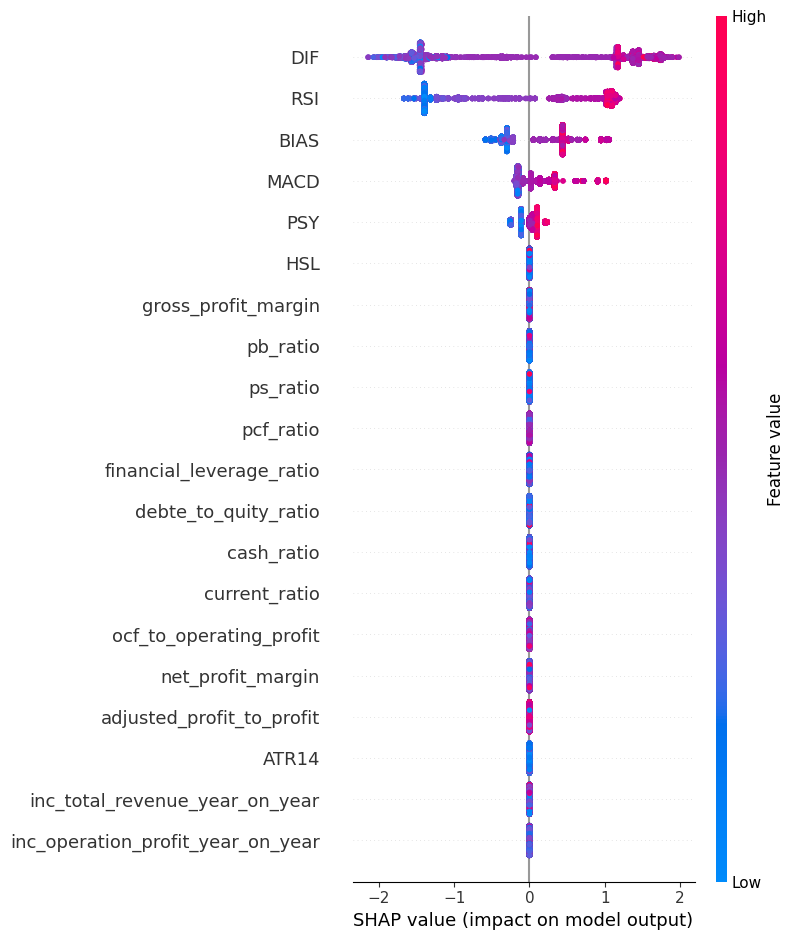

In [295]:
xgb.fit(X,y)
X_test = test_df_labeled.iloc[:, :-1]
y_test = test_df_labeled['return_bin']
# X_test_transformed = selector.transform(X_test)  # Transform test data with the same selector used for training

# Initialize the SHAP explainer with the model
explainer = shap.TreeExplainer(xgb.get_booster())

# Calculate SHAP values for the transformed test data
shap_values = explainer.shap_values(X_test)

# Plot the SHAP values - Summary Plot as an example
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns.tolist())